In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [4]:
n = 4         # number of input qubits
s = '1011'    # the binary hidden shift string

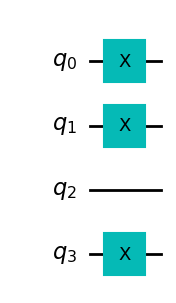

In [5]:
def shift_s(n, s):
    """Shifting operation for the given string s"""
    shift_s = QuantumCircuit(n)
    s = s[::-1]    # reverse s to fit qiskit's qubit ordering
    for i in range(n):
        if s[i] == '0': 
            continue
        else:
            shift_s.x(i)    # apply x gates to shift the input
    shift_s.name = 'Shift'
    return shift_s

# Display circuit
shift_s(n, s).draw('mpl')

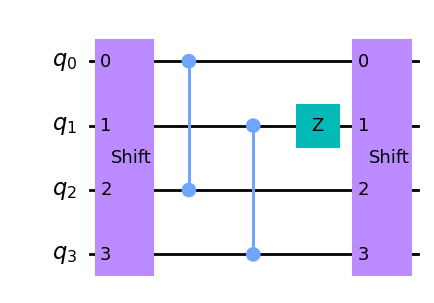

In [6]:
def oracle_g(n):
    """Oracle circuit that encodes g = U_g"""
    oracle_g = QuantumCircuit(n)
    
    # Shift the inputs
    oracle_g.append(shift_s(n, s), range(n))
    
    # Apply the oracle U_f = (-1)^f(x) = F(x)
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_g.cz(i, i+int(n/2))
    
    # h(x) = x·e_2 corresponds to the z gate on the second qubit = q1
    oracle_g.z(1)
    
    # Undo the shift
    oracle_g.append(shift_s(n, s), range(n))
    
    oracle_g.name = 'Oracle g'
    return oracle_g

# Display circuit
oracle_g(n).draw('mpl')

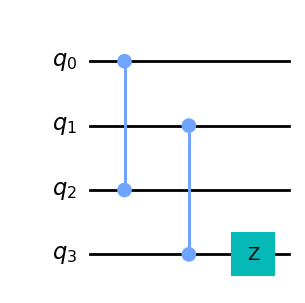

In [7]:
def oracle_f_tilde(n):
    """Oracle circuit that encodes Fourier transformed f = U_f tilde"""
    oracle_f_tilde = QuantumCircuit(n)
    
    # Apply the oracle U_f tilde
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_f_tilde.cz(i, i+int(n/2))
    
    # Apply h(y) = y·e_2, which corresponds to the z gate on the second qubit of the second register = q3
    oracle_f_tilde.z(3)
    
    oracle_f_tilde.name = 'Oracle f tilde'
    return oracle_f_tilde

# Display circuit
oracle_f_tilde(n).draw('mpl')

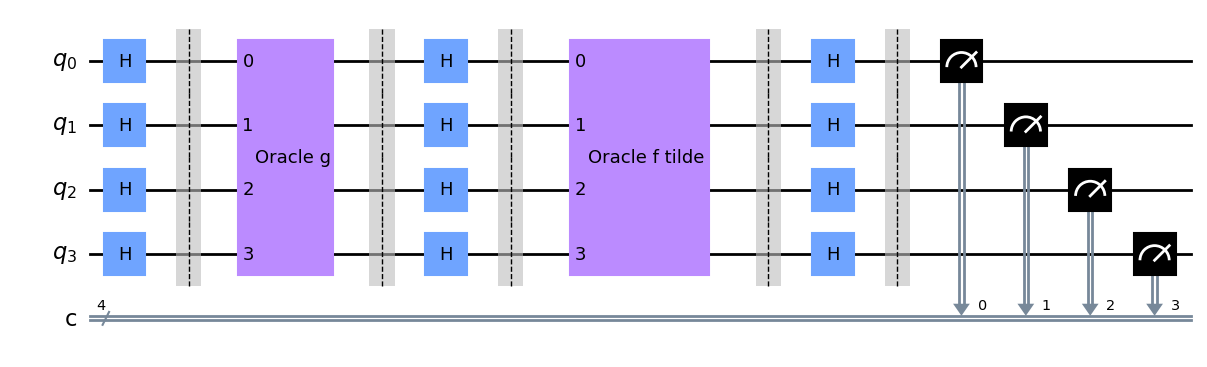

In [8]:
hsp_circuit = QuantumCircuit(n, n)

# Apply Hadamard gates to make superposition
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()    # barrier is for visual separation

# Query the oracle g by appending the oracle circuit on ours
hsp_circuit.append(oracle_g(n), range(n))
hsp_circuit.barrier()

# Apply Hadamard gates to perform a boolean Fourier transform
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Query the oracle f tilde
hsp_circuit.append(oracle_f_tilde(n), range(n))
hsp_circuit.barrier()

# Retrieve s by performing the boolean Fourier transform again
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Measure all qubits
for i in range(n):
    hsp_circuit.measure(i, i)

# Display circuit
hsp_circuit.draw('mpl')

/tmp/ipykernel_751/779732445.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  results = aer_sim.run(qobj).result()


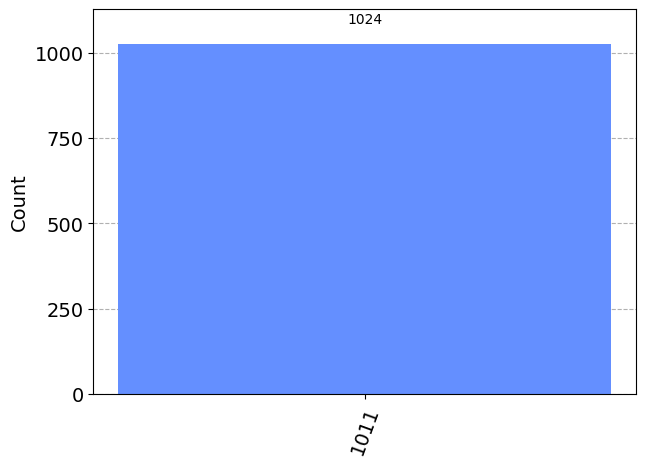

In [9]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [10]:
# Load our saved IBMQ accounts and get the least busy backend device with more than or equal to n qubits
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x:
                                       int(x.configuration().n_qubits) <= 4*n
                                       and int(x.configuration().n_qubits) >= n
                                       and not x.configuration().simulator
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/tmp/ipykernel_751/96355578.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


least busy backend:  ibmq_lima


In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_hsp_circuit = transpile(hsp_circuit, backend)
job = backend.run(transpiled_hsp_circuit, shots=shots)

job_monitor(job, interval=2)

# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Job Status: job is queued (None)